In [9]:
from torch_geometric.data import Data
import torch
import numpy as np
from collections import Counter
from itertools import combinations
from torch.utils.data import Dataset
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [4]:
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
val_diagnoses = pd.read_hdf(f'{hdf}val/diagnoses.h5',key='df')
test_diagnoses = pd.read_hdf(f'{hdf}test/diagnoses.h5',key='df')

print("the size of train diagnoses is: ", train_diagnoses.shape)
print("the size of val diagnoses is: ", val_diagnoses.shape)
print("the size of test diagnoses is: ", test_diagnoses.shape)

the size of train diagnoses is:  (2150, 119)
the size of val diagnoses is:  (461, 119)
the size of test diagnoses is:  (461, 119)


In [5]:
train_diagnoses

,Cardiovascular (R),Cardiovascular (R)|AICD,Cardiovascular (R)|Angina,Cardiovascular (R)|Arrhythmias,Cardiovascular (R)|Arrhythmias|atrial fibrillation - chronic,Cardiovascular (R)|Arrhythmias|atrial fibrillation - intermittent,Cardiovascular (R)|Congestive Heart Failure,Cardiovascular (R)|Congestive Heart Failure|CHF,Cardiovascular (R)|Congestive Heart Failure|CHF - severity unknown,Cardiovascular (R)|Coronary Artery Bypass,...,apacheadmissiondx_Rhythm disturbance (conduction defect),apacheadmissiondx_Seizures (primary-no structural brain disease),"apacheadmissiondx_Sepsis, GI","apacheadmissiondx_Sepsis, cutaneous/soft tissue","apacheadmissiondx_Sepsis, pulmonary","apacheadmissiondx_Sepsis, renal/UTI (including bladder)","apacheadmissiondx_Sepsis, unknown",grouped_apacheadmissiondx_GI,"grouped_apacheadmissiondx_Overdose,","grouped_apacheadmissiondx_Pneumonia,"
patient,,,,,,,,,,,,,,,,,,,,,
260132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
261021,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
270853,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
282833,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
306940,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246280,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3246409,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3246620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def build_graph_data( diag,min_cooccur=2):
    """
    Build a PyG Data object from a diagnosis DataFrame.
    diag: [n,n_diagnosis] matrix
    min_cooccur: minimum number of co-occurrences to consider an edge
    """
    num_nodes = diag.shape[1]
    edge_counter = Counter() 
    
    for row in diag.values:
        activate = np.where(row ==1)[0] # active nodes
        for i, j in combinations(activate, 2): 
            edge = tuple(sorted([i, j])) # sort to avoid duplicates
            edge_counter[edge] += 1
    
    # keep edges with at least min_cooccur co-occurrences
    edge_list = [(i,j) for (i,j), count in edge_counter.items() if count >= min_cooccur]
    edge_index = torch.tensor(edge_list + [(j,i) for (i,j) in edge_list], dtype=torch.long).T # undirected graph
    
    x = torch.eye(num_nodes)
    
    return Data(x=x, edge_index=edge_index)

In [7]:
train_graph = build_graph_data(train_diagnoses)
val_graph = build_graph_data(val_diagnoses)
test_graph = build_graph_data(test_diagnoses)

In [8]:
print(train_graph)
print(f"Number of nodes: {train_graph.num_nodes}")
print(f"Number of edges: {train_graph.num_edges}")
print(f"Edge index shape: {train_graph.edge_index.shape}")
print(f"Feature matrix shape: {train_graph.x.shape}")

Data(x=[119, 119], edge_index=[2, 7420])
Number of nodes: 119
Number of edges: 7420
Edge index shape: torch.Size([2, 7420])
Feature matrix shape: torch.Size([119, 119])


In [12]:
diag_labels = list(train_diagnoses.columns)

In [18]:
def visualize_subgraph_with_labels(data, diag_labels, num_nodes=10):
    G_nx = to_networkx(data, to_undirected=True)
    subset_nodes = list(range(num_nodes))  # visualize the first 10 nodes
    subgraph = G_nx.subgraph(subset_nodes)

    # set node labels
    labels = {i: diag_labels[i] for i in subset_nodes}

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph, seed=42)  # for consistent layout
    nx.draw(subgraph, pos, with_labels=True, labels=labels, 
            node_color='lightblue', edge_color='gray', node_size=800, font_size=9)
    plt.title("Diagnosis Co-occurrence Subgraph")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1685667/2656199221.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


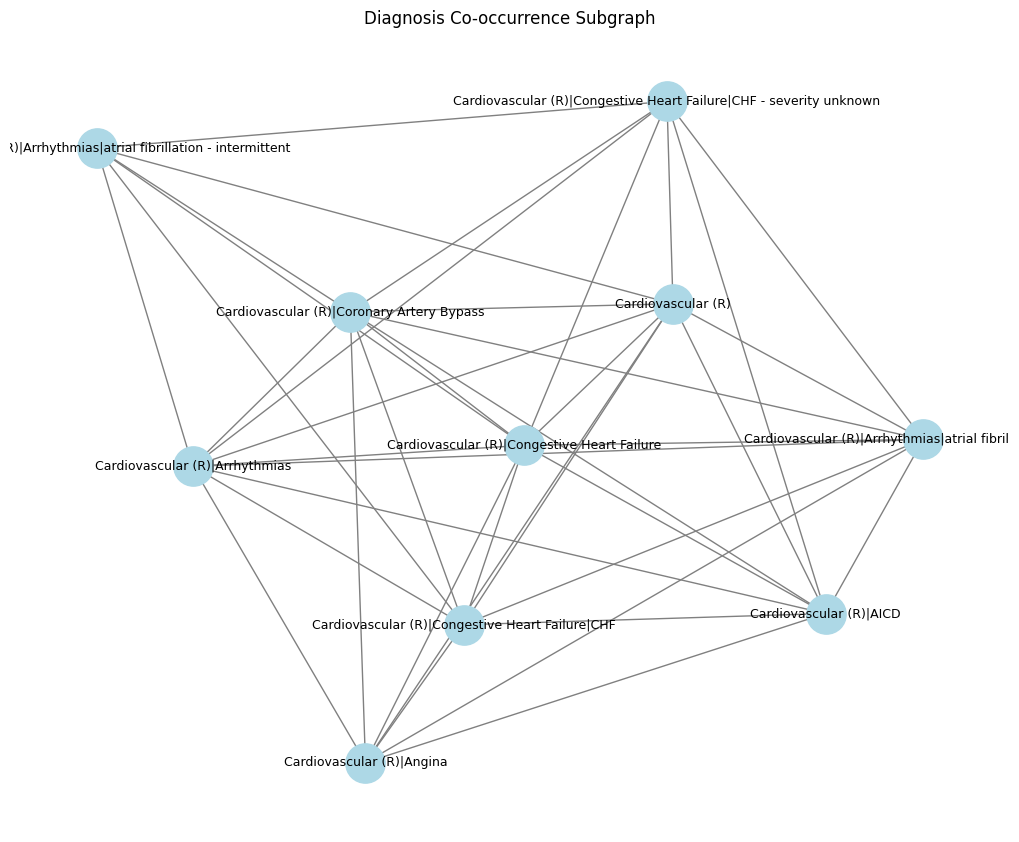

In [19]:
visualize_subgraph_with_labels(train_graph, list(train_diagnoses.columns), num_nodes=10)


In [22]:
def visualize_patient_diagnosis_graph(global_graph, diag_df, patient_id, diag_labels=None):
    """
    visualize the diagnosis graph for a specific patient.
    """
    # 1. get the active nodes for the patient
    if isinstance(patient_id, str):
        patient_id = int(patient_id)

    row = diag_df.loc[patient_id].values  # shape: [119]
    active_nodes = [i for i, val in enumerate(row) if val == 1]

    if len(active_nodes) < 1:
        print(f"[Warning] Patient {patient_id} has no active diagnoses.")
        return

    # 2. take the subgraph of the active nodes
    G = to_networkx(global_graph, to_undirected=True)
    subG = G.subgraph(active_nodes)

    # 3. diagnosis labels
    if diag_labels is None:
        labels = {i: f"DX{i}" for i in active_nodes}
    else:
        labels = {i: diag_labels[i] for i in active_nodes}

    # 4. visualize the subgraph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(subG, seed=42)
    nx.draw(subG, pos, with_labels=True, labels=labels,
            node_color='lightblue', node_size=800, font_size=9, edge_color='gray')
    plt.title(f"Patient {patient_id} Diagnosis Graph")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1685667/1343963601.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


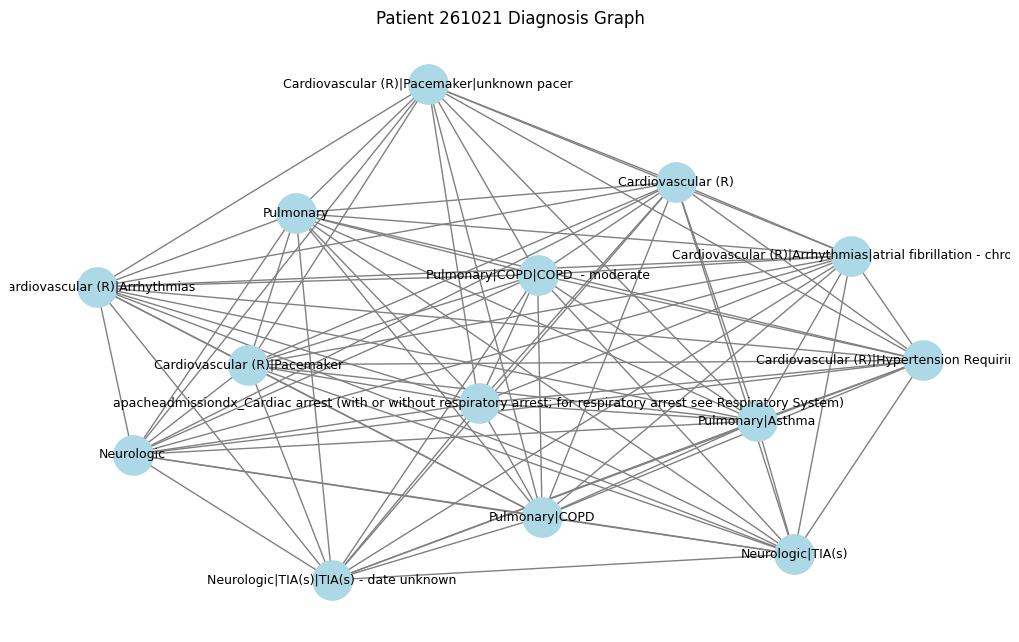

In [23]:
visualize_patient_diagnosis_graph(train_graph, train_diagnoses, patient_id=261021, diag_labels=list(train_diagnoses.columns))

In [27]:
def get_patient_active_diagnoses(diag_df, patient_id):
    """
    get the active diagnoses for a specific patient.
    """
    if isinstance(patient_id, str):
        patient_id = int(patient_id)

    row = diag_df.loc[patient_id]
    active = row[row == 1.0].index.tolist()
    return active


In [28]:
active_diag = get_patient_active_diagnoses(train_diagnoses, patient_id=261021)
print(f"Patient 261021 activated diagnoses:\n", active_diag)

Patient 261021 activated diagnoses:
 ['Cardiovascular (R)', 'Cardiovascular (R)|Arrhythmias', 'Cardiovascular (R)|Arrhythmias|atrial fibrillation - chronic', 'Cardiovascular (R)|Hypertension Requiring Treatment', 'Cardiovascular (R)|Pacemaker', 'Cardiovascular (R)|Pacemaker|unknown pacer', 'Neurologic', 'Neurologic|TIA(s)', 'Neurologic|TIA(s)|TIA(s) - date unknown', 'Pulmonary', 'Pulmonary|Asthma', 'Pulmonary|COPD', 'Pulmonary|COPD|COPD  - moderate', 'apacheadmissiondx_Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System)']
